In [1]:
import os.path as op
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from ordering_methods import create_order_3_channels, create_order_single_channel

In [2]:
# prefix = "/work/scratch/malinoro/histogram_transfer"
prefix = "/Users/roman/Code/Histogram_transfer"

# Reading or creating images

In [46]:
img1 = cv.cvtColor(cv.imread(op.join(prefix, "conesF", "im2.ppm")), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread(op.join(prefix, "teddyF", "im2.ppm")), cv.COLOR_BGR2RGB)
img1 = cv.resize(img1, dsize=(360, 300))
img2 = cv.resize(img2, dsize=(360, 300))

## Fake image
X, Y = np.meshgrid(np.linspace(0, 255, img1.shape[1]), np.linspace(0, 255, img1.shape[0]))
R, G, B = np.sqrt((X**2+Y**2)/2), np.sqrt(((255-X)**2+Y**2)/2), np.sqrt(((255-X)**2+(255-Y)**2)/2)
R, G, B = R.astype(dtype=np.uint8), G.astype(dtype=np.uint8), B.astype(dtype=np.uint8) 
img0 = cv.merge([B, G, R])

# Choosing and image, smoothing it, HSV, and separating channels

In [47]:
img = img1
img_ref = img0

# HSV
hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
hsv_ref = cv.cvtColor(img_ref, cv.COLOR_BGR2HSV)

# Smooth image
img_smooth = cv.GaussianBlur(img, (5, 5), 0)
hsv_smooth = cv.GaussianBlur(hsv_img, (5, 5), 0)

# Separating channels
bgr_planes = cv.split(img)
bgr_ref_planes = cv.split(img_ref)
bgr_smooth_planes = cv.split(img_smooth)

hsv_planes = cv.split(hsv_img)
hsv_ref_planes = cv.split(hsv_ref)
hsv_smooth_planes = cv.split(hsv_smooth)

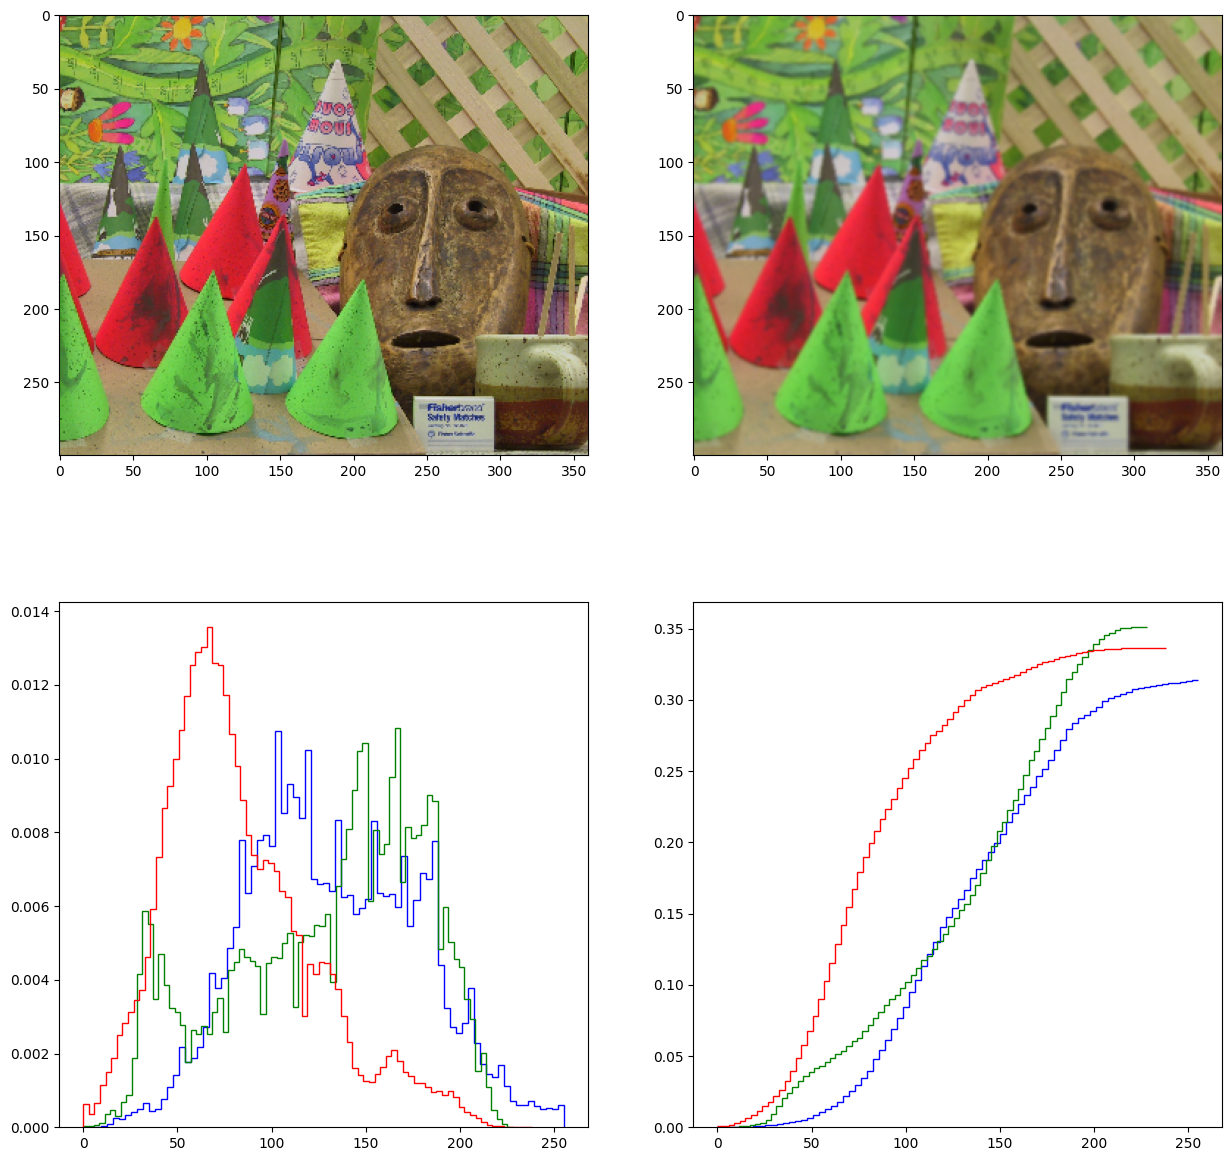

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes[0,0].imshow(img)
axes[0,1].imshow(img_smooth)

n_bins = 80
for k, c in zip(range(3), ["b", "g", "r"]):
    counts, bins = np.histogram(bgr_planes[k], bins=n_bins, density=True)
    axes[1,0].stairs(counts, bins, color=c)
    axes[1,1].stairs(np.cumsum(counts), bins, baseline=None, color=c)
    
plt.show()

In [ ]:
cumulated_hist = True

bins_3d = (20, 20, 20)
X, Y, Z = np.meshgrid(*[np.linspace(0, 255, b) for b in bins_3d])

# This compute the histogram in N dimensions
if cumulated_hist:
    counts, _ = np.histogramdd(np.array(img).reshape(-1, 3), bins=bins_3d)
    counts = counts.cumsum(axis=0).cumsum(axis=1).cumsum(axis=2) / np.sum(counts)
    iso_min, iso_max = 0, 1
else:
    counts, _ = np.histogramdd(np.array(img).reshape(-1, 3), bins=bins_3d, density=True)
    iso_min, iso_max = np.quantile(counts, 0.5), counts.max()

    
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    isomin=iso_min,
    isomax=iso_max,
    value=counts.flatten(),
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))

fig.update_layout(autosize=False, width=500, height=500, scene=dict(xaxis_title='Blue', yaxis_title='Green', zaxis_title='Red'))
fig.show()

### This proves that the histogram is correctly computed (raw format)

## Sorting the image for RGB

In [49]:
order_ref = create_order_3_channels(img_ref)
order = create_order_3_channels(img, img_smooth, complete=True)


10332/10332


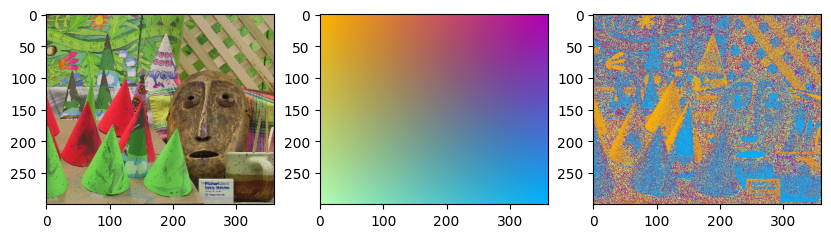

In [50]:
img_transfered = img.copy()
img_transfered[order] = img_ref[order_ref]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(img_transfered)

## Sorting the image for RGB taken separetly

In [51]:
b_order_ref = create_order_single_channel(bgr_ref_planes[0])
b_order = create_order_single_channel(bgr_planes[0], bgr_smooth_planes[0], complete=True)
b_transfered = bgr_planes[0].copy()
b_transfered[b_order] = bgr_ref_planes[0][b_order_ref]

g_order_ref = create_order_single_channel(bgr_ref_planes[1])
g_order = create_order_single_channel(bgr_planes[1], bgr_smooth_planes[1], complete=True)
g_transfered = bgr_planes[1].copy()
g_transfered[g_order] = bgr_ref_planes[1][g_order_ref]

r_order_ref = create_order_single_channel(bgr_ref_planes[2])
r_order = create_order_single_channel(bgr_planes[2], bgr_smooth_planes[2], complete=True)
r_transfered = bgr_planes[2].copy()
r_transfered[r_order] = bgr_ref_planes[2][r_order_ref]

img_channels_transfered = cv.merge([b_transfered, g_transfered, r_transfered])


252/252

225/225

225/225


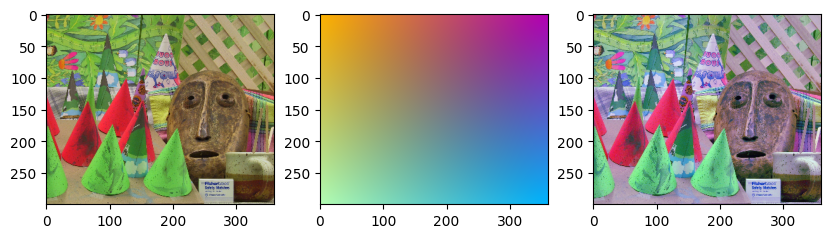

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(img_channels_transfered)

plt.show()

## Sorting the image for HSV

In [53]:
order_ref = create_order_3_channels(hsv_ref)
order = create_order_3_channels(hsv_img, hsv_smooth, complete=True)


15178/15178


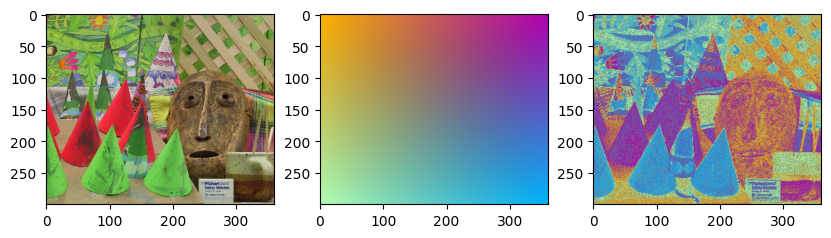

In [54]:
hsv_transfered = hsv_img.copy()
hsv_transfered[order] = hsv_ref[order_ref]
hsv_transfered = cv.cvtColor(hsv_transfered, cv.COLOR_HSV2BGR)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(hsv_transfered)

## Sorting the image for HSV taken separetly

In [55]:
h_order_ref = create_order_single_channel(hsv_ref_planes[0])
h_order = create_order_single_channel(hsv_planes[0], hsv_smooth_planes[0], complete=True)
h_transfered = hsv_planes[0].copy()
h_transfered[h_order] = hsv_ref_planes[0][h_order_ref]

s_order_ref = create_order_single_channel(hsv_ref_planes[1])
s_order = create_order_single_channel(hsv_planes[1], hsv_smooth_planes[1], complete=True)
s_transfered = hsv_planes[1].copy()
s_transfered[s_order] = hsv_ref_planes[1][s_order_ref]

v_order_ref = create_order_single_channel(hsv_ref_planes[2])
v_order = create_order_single_channel(hsv_planes[2], hsv_smooth_planes[2], complete=True)
v_transfered = hsv_planes[2].copy()
v_transfered[v_order] = hsv_ref_planes[2][v_order_ref]

hsv_channels_transfered = cv.cvtColor(cv.merge([h_transfered, s_transfered, v_transfered]), cv.COLOR_HSV2BGR)


180/180

255/255

245/245


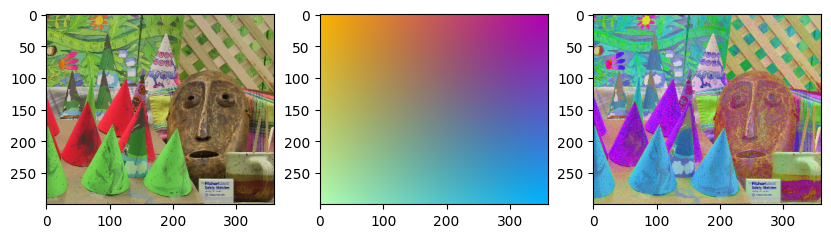

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(hsv_channels_transfered)

plt.show()

# Plotting all methods at once

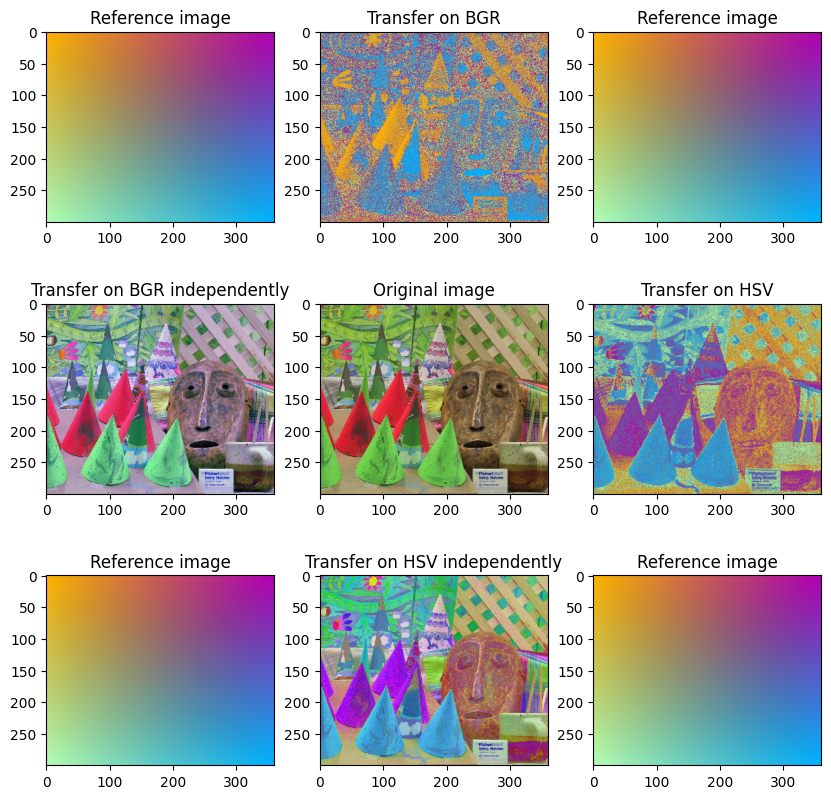

In [57]:
hsv_channels_transfered 
hsv_transfered 
img_channels_transfered
img_transfered

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes[0,1].imshow(img_transfered)
axes[1,0].imshow(img_channels_transfered)
axes[1,2].imshow(hsv_transfered)
axes[2,1].imshow(hsv_channels_transfered)

axes[0,1].set_title("Transfer on BGR")
axes[1,0].set_title("Transfer on BGR independently")
axes[1,2].set_title("Transfer on HSV")
axes[2,1].set_title("Transfer on HSV independently")


axes[0,0].imshow(img_ref)
axes[0,2].imshow(img_ref)
axes[2,0].imshow(img_ref)
axes[2,2].imshow(img_ref)
axes[1,1].imshow(img)

axes[0,0].set_title("Reference image")
axes[0,2].set_title("Reference image")
axes[2,0].set_title("Reference image")
axes[2,2].set_title("Reference image")
axes[1,1].set_title("Original image")



plt.show()

# Statistics

In [58]:
np.cov(np.array([g_transfered.flatten(), b_transfered.flatten(), r_transfered.flatten()]))

array([[2653.49753684,  620.5515929 , 1688.55990779],
       [ 620.5515929 , 2653.49753684, 1464.342378  ],
       [1688.55990779, 1464.342378  , 2653.49753684]])

In [59]:
np.cov(np.array([h_transfered.flatten(), s_transfered.flatten(), v_transfered.flatten()]))

array([[2575.17536744,   54.30461703,  -74.7075834 ],
       [  54.30461703, 2747.41337227,   76.82870643],
       [ -74.7075834 ,   76.82870643,  741.59172122]])

In [61]:
a = np.arange(4*2*3, dtype=np.uint8).reshape(4,2,3)
a.dtype = np.dtype([('H', np.uint8), ('S', np.uint8), ('V', np.uint8)])
a

array([[[( 0,  1,  2)],
        [( 3,  4,  5)]],

       [[( 6,  7,  8)],
        [( 9, 10, 11)]],

       [[(12, 13, 14)],
        [(15, 16, 17)]],

       [[(18, 19, 20)],
        [(21, 22, 23)]]], dtype=[('H', 'u1'), ('S', 'u1'), ('V', 'u1')])

In [62]:
b = np.arange(4*2*3, 4*2*3*2, dtype=np.uint8).reshape(4,2,3)
b.dtype = np.dtype([('H1', np.uint8), ('S1', np.uint8), ('V1', np.uint8)])
b

array([[[(24, 25, 26)],
        [(27, 28, 29)]],

       [[(30, 31, 32)],
        [(33, 34, 35)]],

       [[(36, 37, 38)],
        [(39, 40, 41)]],

       [[(42, 43, 44)],
        [(45, 46, 47)]]], dtype=[('H1', 'u1'), ('S1', 'u1'), ('V1', 'u1')])

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

numpy.ndarray